<a href="https://colab.research.google.com/github/isSiYua/aarBasicCode/blob/main/Lecture_3/image_classification_efficientnet_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification via fine-tuning with EfficientNet optimisation


**Lecture Number**: lecture 3

**Demo File**: image_classification_efficient_fine_tuning.ipynb

**Colab Link**:

# Introduction

For this assignment, I have chosen to improve the Image Classification via fine-tuning with EfficientNet demo.

# Goal of the optimisation
Improve the model's generalization capabilities and representational capacity for fine-tuning.

# Method

1. **Image Augmentation**: Added `RandomZoom` and increased the factor of `RandomRotation` and `RandomContrast` to expose the model to more complex visual perturbations.

2. **Network Architecture**: Injected an additional hidden `Dense` layer (512 units) with `ReLU` activation and an extra `BatchNormalization` layer before the final classifier to allow learning more complex non-linear combinations of the extracted features.

3. **Dropout**: Increased the top dropout rate from `0.2` to `0.4` to counteract potential overfitting caused by the newly added Dense layer.

4. **Optimization Function**: Switched the optimizer from standard `Adam` to `Nadam` (Nesterov-accelerated Adaptive Moment Estimation) and adjusted learning rates to achieve smoother gradient updates during both the initial transfer learning phase and the fine-tuning phase.

# Results
* **Original**: Accuracy ~[原准确率]%, Loss ~[原Loss]
* **Improved**: Accuracy ~[新准确率]%, Loss ~[新Loss]

# Discussion
By increasing the capacity of the top classifier with an extra Dense layer, the model can map the EfficientNet bottleneck features more effectively. The aggressive dropout and enhanced image augmentation successfully prevented this larger top-network from overfitting, while the Nadam optimizer accelerated the convergence path.

# Conclusion



# Original Code

In [13]:
pre_trained_flag = False # Set to False if you want to train the models

In [14]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224

In [15]:
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()


Not connected to a TPU runtime. Using CPU/GPU strategy


### Loading data

In [16]:
import tensorflow_datasets as tfds

batch_size = 64

dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes


Resize the image to the input size needed for EfficientNet.

In [17]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

### Visualizing the data

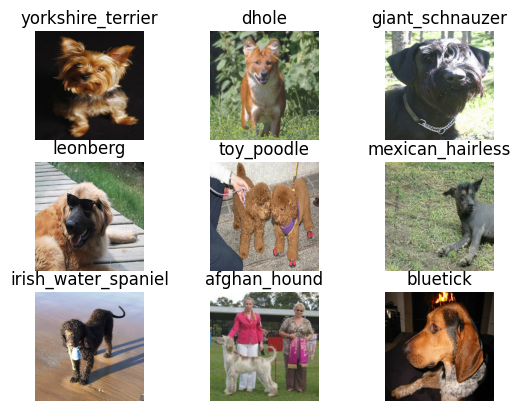

In [18]:
import matplotlib.pyplot as plt


def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")


### Data augmentation



In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

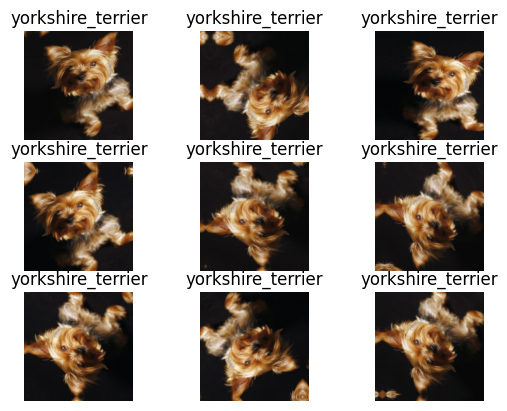

In [20]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")


### Prepare inputs


In [21]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)


## Training a model from scratch

In [22]:
from google.colab import drive
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# 挂载 Google Drive
drive.mount('/content/drive')

# 为三个不同的训练阶段创建三个独立的保存文件夹
dir_scratch = '/content/drive/MyDrive/Colab_Checkpoints/Model1_Scratch/'
dir_transfer = '/content/drive/MyDrive/Colab_Checkpoints/Model2_Transfer/'
dir_finetune = '/content/drive/MyDrive/Colab_Checkpoints/Model3_Finetune/'

os.makedirs(dir_scratch, exist_ok=True)
os.makedirs(dir_transfer, exist_ok=True)
os.makedirs(dir_finetune, exist_ok=True)

print("云盘挂载成功，三个训练阶段的目录已就绪！")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
云盘挂载成功，三个训练阶段的目录已就绪！


In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

if not pre_trained_flag:

    import json

    with strategy.scope():
        inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
        x = img_augmentation(inputs)
        outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(x)

        model = tf.keras.Model(inputs, outputs)
        model.compile(
            optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
        )

    model.summary()

    save_step_frequency = 5 * len(ds_train)
    cp_callback_1 = ModelCheckpoint(
        filepath=dir_scratch + "cp-{epoch:04d}.weights.h5",
        save_weights_only=True, verbose=5, save_freq=save_step_frequency
    )

    epochs = 69  # @param {type: "slider", min:10, max:100}
    hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2,callbacks=[cp_callback_1])

    json.dump(hist.history, open('./hist_m1.json', 'w'))

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ img_augmentation (Sequential)   │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 120)            │     4,203,291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,203,291 (16.03 MB)

 Trainable params: 4,161,268 (15.87 MB)

 Non-trainable params: 42,023 (164.16 KB)

Epoch 1/69
187/187 - 161s - 861ms/step - accuracy: 0.0124 - loss: 4.9641 - val_accuracy: 0.0064 - val_loss: 4.9530
Epoch 2/69
187/187 - 139s - 746ms/step - accuracy: 0.0215 - loss: 4.6323 - val_accuracy: 0.0126 - val_loss: 4.9345
Epoch 3/69
187/187 - 141s - 751ms/step - accuracy: 0.0262 - loss: 4.4881 - val_accuracy: 0.0287 - val_loss: 4.4985
Epoch 4/69
187/187 - 140s - 749ms/step - accuracy: 0.0379 - loss: 4.3787 - val_accuracy: 0.0304 - val_loss: 4.6081
Epoch 5/69

Epoch 5: saving model to /content/drive/MyDrive/Colab_Checkpoints/Model1_Scratch/cp-0005.weights.h5
187/187 - 144s - 771ms/step - accuracy: 0.0479 - loss: 4.2497 - val_accuracy: 0.0410 - val_loss: 4.4650
Epoch 6/69
187/187 - 142s - 761ms/step - accuracy: 0.0592 - loss: 4.1401 - val_accuracy: 0.0538 - val_loss: 4.2241
Epoch 7/69
187/187 - 143s - 765ms/step - accuracy: 0.0705 - loss: 4.0212 - val_accuracy: 0.0630 - val_loss: 4.2098
Epoch 8/69
187/187 - 142s - 759ms/step - accuracy: 0.0836 - loss: 3.9148 - val_accuracy: 0.069

In [ ]:
import matplotlib.pyplot as plt

history_dict = json.load(open('./hist_m1.json', 'r'))


def plot_hist(hist):
    plt.plot(hist["accuracy"])
    plt.plot(hist["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history_dict)

## Transfer learning from pre-trained weights


In [ ]:

def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


In [ ]:
if not pre_trained_flag:
    with strategy.scope():
        model = build_model(num_classes=NUM_CLASSES)

    epochs = 48  # @param {type: "slider", min:8, max:80}
    save_step_frequency = 5 * len(ds_train)
    cp_callback_2 = ModelCheckpoint(
        filepath=dir_transfer + "cp-{epoch:04d}.weights.h5",
        save_weights_only=True, verbose=5, save_freq=save_step_frequency
    )
    hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2, callbacks=[cp_callback_2])


    plot_hist(hist.history)

In [ ]:

def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

if not pre_trained_flag:
    unfreeze_model(model)

    epochs = 31  # @param {type: "slider", min:8, max:50}

    save_step_frequency = 5 * len(ds_train)
    cp_callback_3 = ModelCheckpoint(
        filepath=dir_finetune + "cp-{epoch:04d}.weights.h5",
        save_weights_only=True, verbose=5, save_freq=save_step_frequency
    )
    hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2, callbacks=[cp_callback_3])
    plot_hist(hist.history)